In [1]:
!pip install tensorflow matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


**<h2>데이터셋 다운로드</h2>**

<h5>데이터셋이 없을 때 실행</h5>

In [4]:
!pip install kaggle


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
#!/bin/bash
!kaggle datasets download phylake1337/fire-dataset

404 - Not Found


In [6]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
replace fire_dataset/fire_images/fire.1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
%matplotlib inline
import os
import cv2

이미지 파일의 확장자를 읽어내고 문제가 있는 파일을 삭제하는 코드

In [8]:
import imghdr

/tmp/ipykernel_58658/336752527.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [9]:
data_dir = './fire_dataset'

image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**<h3>1. CNN 모델 <h3>**

**<h4>이미지 데이터 전처리</h4>**

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf

2024-12-10 16:42:28.839933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733848948.906414   58658 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733848948.919713   58658 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 16:42:28.991221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 992 files belonging to 2 classes.


2024-12-10 16:42:32.239718: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-12-10 16:42:32.315368: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53388252 exceeds 10% of free system memory.
2024-12-10 16:42:32.401375: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62005248 exceeds 10% of free system memory.
2024-12-10 16:42:32.410098: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59640000 exceeds 10% of free system memory.
2024-12-10 16:42:32.410320: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66355200 exceeds 10% of free system memory.


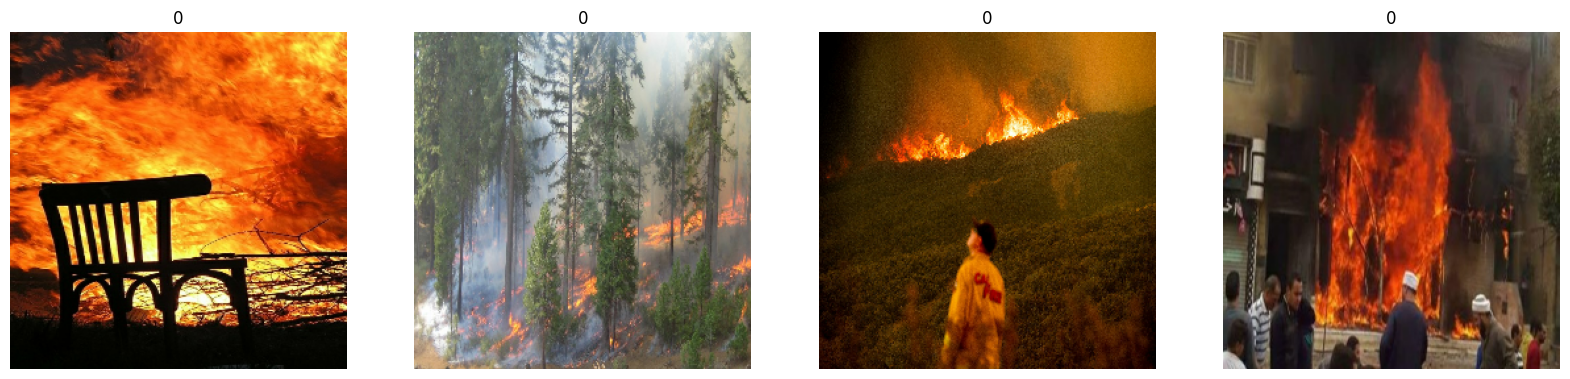

In [11]:
data = tf.keras.utils.image_dataset_from_directory('./fire_dataset')

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')
plt.show()

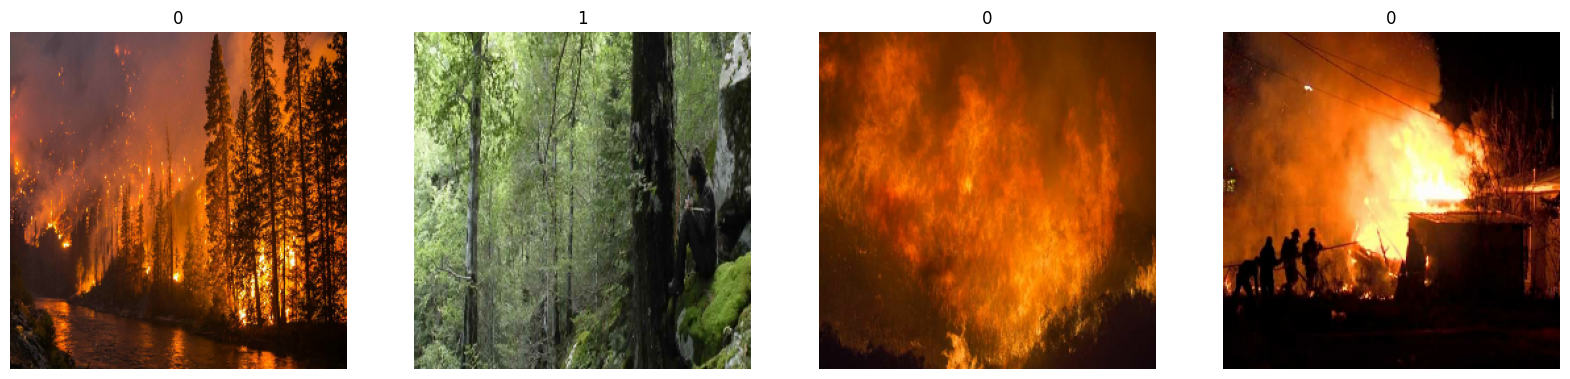

In [12]:
data = data.map(lambda x,y: (x/255, y)) #데이터 정규화

batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')

In [13]:
#데이터 셋 분할
train_size = int(len(data)*.7) + 1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

**<h4> 모델 구성 </h4>**

In [14]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


2024-12-10 16:42:35.316328: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 66355200 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - accuracy: 0.6871 - loss: 0.9042 - val_accuracy: 0.8854 - val_loss: 0.3026
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 779ms/step - accuracy: 0.8924 - loss: 0.2806 - val_accuracy: 0.9375 - val_loss: 0.1493
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 769ms/step - accuracy: 0.9458 - loss: 0.1314 - val_accuracy: 0.9740 - val_loss: 0.0681
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 817ms/step - accuracy: 0.9648 - loss: 0.1003 - val_accuracy: 0.9479 - val_loss: 0.1024
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 801ms/step - accuracy: 0.9548 - loss: 0.0944 - val_accuracy: 0.9792 - val_loss: 0.0576
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 775ms/step - accuracy: 0.9627 - loss: 0.1120 - val_accuracy: 0.9844 - val_loss: 0.0778
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 830ms/step - accuracy: 0.9763 - loss: 0.0662 - val_accuracy: 0.9688 - val_loss: 0.0645
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 830ms/step - accuracy: 0.9858 - loss: 0.0461 - val_accuracy: 0.958

<h5> model_v2 모델</h5>
<h5> - fiters, units 하이퍼파라미터 값 변경</h5>

In [17]:
model_v2 = Sequential()

model_v2.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_v2.add(MaxPooling2D())
model_v2.add(Conv2D(64, (3,3), 1, activation='relu'))
model_v2.add(MaxPooling2D())
model_v2.add(Conv2D(128, (3,3), 1, activation='relu'))
model_v2.add(MaxPooling2D())
model_v2.add(Flatten())

model_v2.add(Dense(128, activation='relu'))
model_v2.add(Dense(64, activation='relu'))
model_v2.add(Dense(1, activation='sigmoid'))

In [18]:
model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 14,847,297 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_v2.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_v2 = model_v2.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7440 - loss: 0.7461 - val_accuracy: 0.9583 - val_loss: 0.1068
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8835 - loss: 0.3048 - val_accuracy: 0.9010 - val_loss: 0.2304
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9343 - loss: 0.1935 - val_accuracy: 0.9844 - val_loss: 0.0459
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9642 - loss: 0.1025 - val_accuracy: 0.9792 - val_loss: 0.0661
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9665 - loss: 0.0911 - val_accuracy: 0.9635 - val_loss: 0.0896
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9665 - loss: 0.0847 - val_accuracy: 0.9688 - val_loss: 0.0699
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9601 - loss: 0.1022 - val_accuracy: 0.9427 - val_loss: 0.1421
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9721 - loss: 0.0948 - val_accuracy: 0.9635 - val_loss:

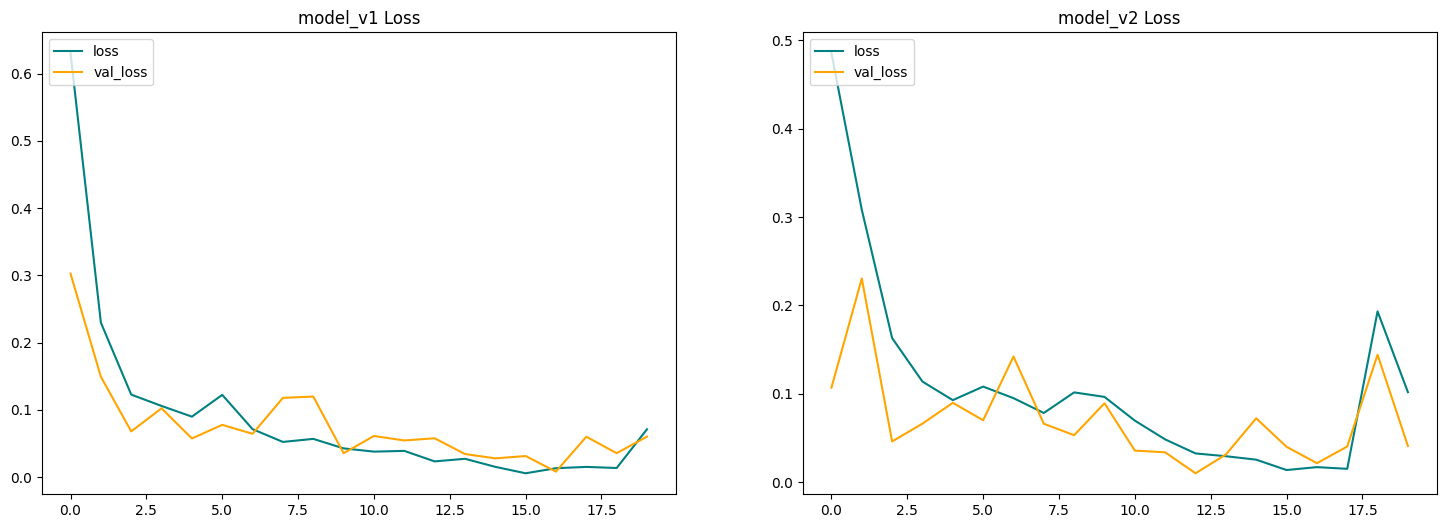

In [20]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('model_v1 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(hist_v2.history['loss'], color='teal', label='loss')
plt.plot(hist_v2.history['val_loss'], color='orange', label='val_loss')
plt.title('model_v2 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.show()

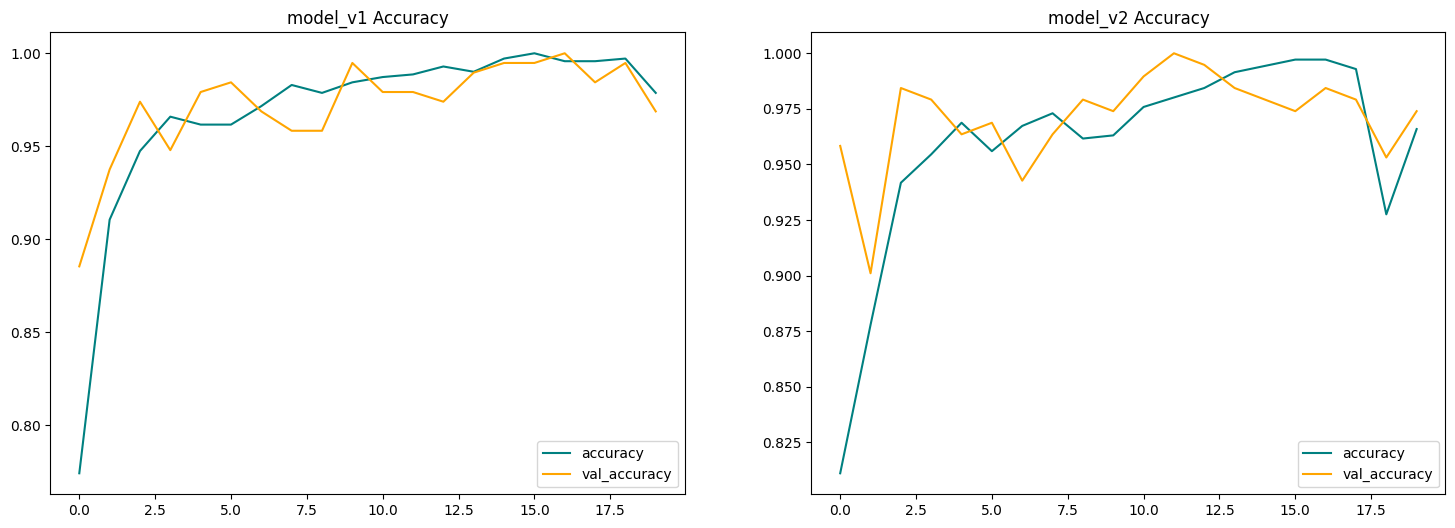

In [21]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('model_v1 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(hist_v2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_v2.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('model_v2 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.show()

<h5> model_v3 모델</h5>
<h5> - model_v1 dropout 추가</h5>

In [22]:
model_v3 = Sequential()

model_v3.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_v3.add(MaxPooling2D())
model_v3.add(Conv2D(32, (3,3), 1, activation='relu'))
model_v3.add(MaxPooling2D())
model_v3.add(Conv2D(16, (3,3), 1, activation='relu'))
model_v3.add(MaxPooling2D())
model_v3.add(Flatten())
model_v3.add(Dense(256, activation='relu'))
model_v3.add(Dropout(0.5))
model_v3.add(Dense(1, activation='sigmoid'))

In [23]:
model_v3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_v3.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_v3 = model_v3.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 778ms/step - accuracy: 0.6736 - loss: 1.1148 - val_accuracy: 0.7448 - val_loss: 0.4878
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 818ms/step - accuracy: 0.8500 - loss: 0.3579 - val_accuracy: 0.9688 - val_loss: 0.0983
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 759ms/step - accuracy: 0.9115 - loss: 0.2511 - val_accuracy: 0.9479 - val_loss: 0.1324
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 773ms/step - accuracy: 0.9417 - loss: 0.1502 - val_accuracy: 0.9635 - val_loss: 0.1031
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 752ms/step - accuracy: 0.9442 - loss: 0.1564 - val_accuracy: 0.9427 - val_loss: 0.1198
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 785ms/step - accuracy: 0.9591 - loss: 0.1153 - val_accuracy: 0.9531 - val_loss: 0.1557
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.9492 - loss: 0.1006 - val_accuracy: 0.9688 - val_loss: 0.0936
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 754ms/step - accuracy: 0.9572 - loss: 0.0951 - val_accu

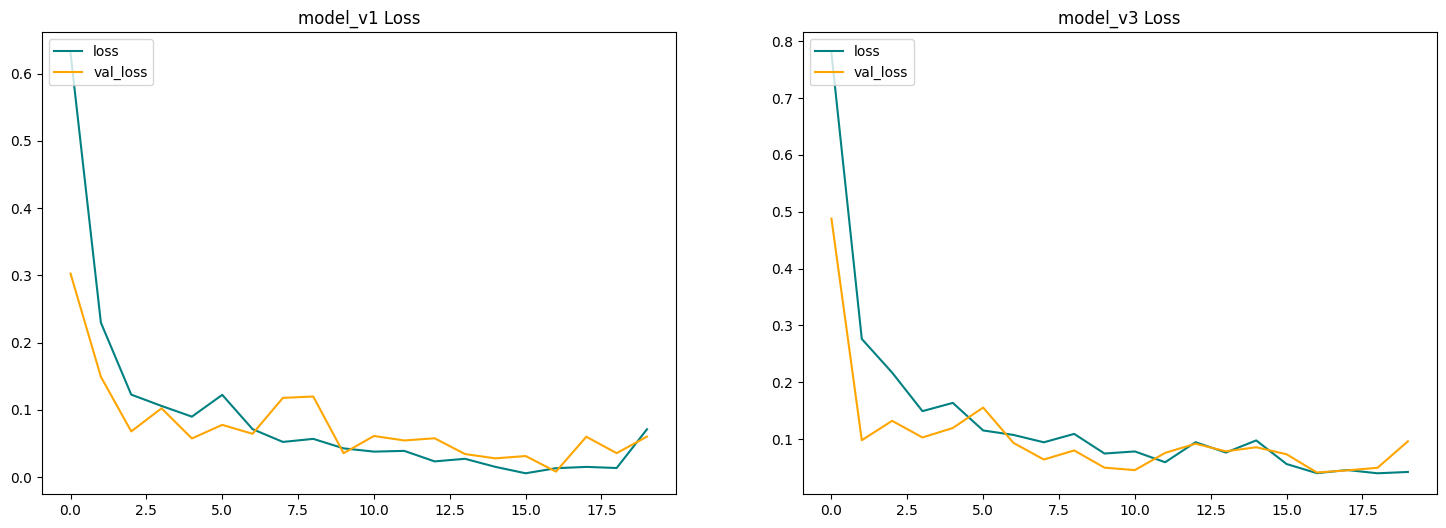

In [25]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('model_v1 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(hist_v3.history['loss'], color='teal', label='loss')
plt.plot(hist_v3.history['val_loss'], color='orange', label='val_loss')
plt.title('model_v3 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.show()

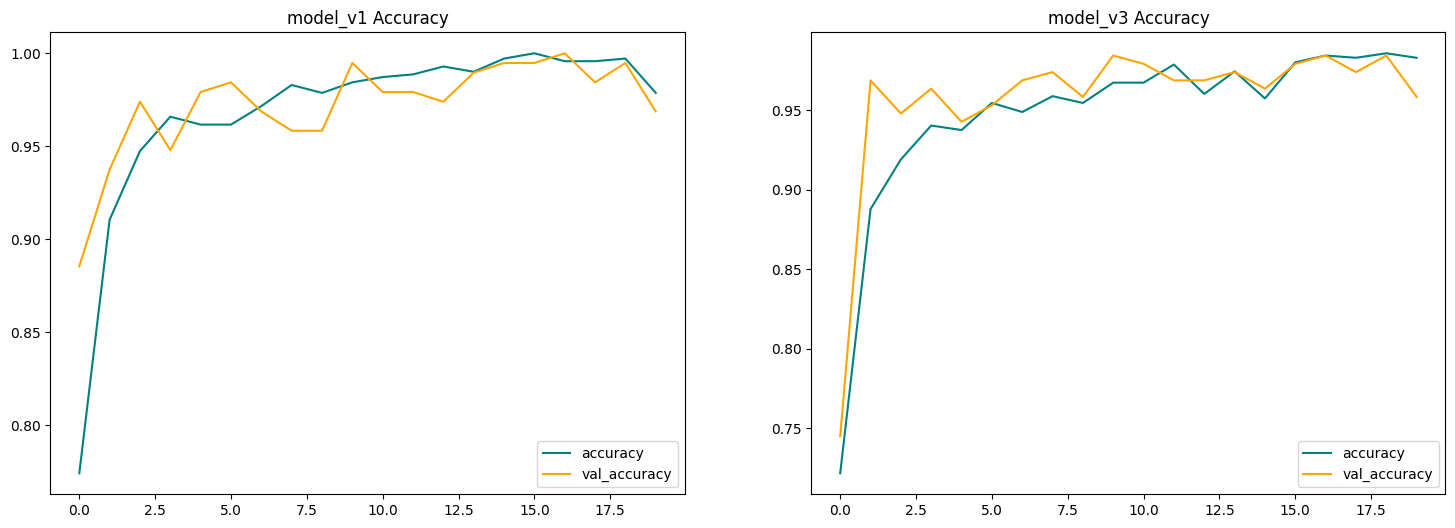

In [26]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('model_v1 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(hist_v3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_v3.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('model_v3 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.show()

**<h4>학습률 조정 </h4>**

<h5> Adam 학습률 : 0.01 </h5>

In [27]:
model1 = clone_model(model)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model1.set_weights(model.get_weights())


In [28]:
hist1 = model1.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 762ms/step - accuracy: 0.7242 - loss: 13.3027 - val_accuracy: 0.7812 - val_loss: 0.5130
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 786ms/step - accuracy: 0.7717 - loss: 0.4891 - val_accuracy: 0.7604 - val_loss: 0.3672
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.8139 - loss: 0.3079 - val_accuracy: 0.9219 - val_loss: 0.2456
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 791ms/step - accuracy: 0.8975 - loss: 0.3564 - val_accuracy: 0.7656 - val_loss: 0.3892
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - accuracy: 0.7698 - loss: 0.4387 - val_accuracy: 0.9323 - val_loss: 0.2928
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 794ms/step - accuracy: 0.9261 - loss: 0.2924 - val_accuracy: 0.8021 - val_loss: 0.4163
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 737ms/step - accuracy: 0.8924 - loss: 0.2564 - val_accuracy: 0.7604 - val_loss: 0.9906
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 747ms/step - accuracy: 0.8985 - loss: 0.3249 - val_acc

<h5> Adam 학습률 : 0.001 </h5>

In [29]:
model2 = clone_model(model)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy', metrics=['accuracy'])
model2.set_weights(model.get_weights())

In [30]:
hist2 = model2.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 773ms/step - accuracy: 0.9872 - loss: 0.0589 - val_accuracy: 0.9896 - val_loss: 0.0555
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 755ms/step - accuracy: 0.9952 - loss: 0.0203 - val_accuracy: 0.9948 - val_loss: 0.0460
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.9620 - loss: 0.1058 - val_accuracy: 0.9688 - val_loss: 0.0909
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 811ms/step - accuracy: 0.9745 - loss: 0.0829 - val_accuracy: 0.9896 - val_loss: 0.0505
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 808ms/step - accuracy: 0.9930 - loss: 0.0292 - val_accuracy: 0.9948 - val_loss: 0.0303
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.9991 - loss: 0.0060 - val_accuracy: 0.9948 - val_loss: 0.0364
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 760ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9948 - val_loss: 0.0469
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 772ms/step - accuracy: 1.0000 - loss: 5.6419e-04 - val_

<h5> Adam 학습률 : 0.0001 </h5>

In [31]:
model3 = clone_model(model)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy', metrics=['accuracy'])
model3.set_weights(model.get_weights())

In [32]:
hist3 = model3.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 771ms/step - accuracy: 0.9898 - loss: 0.0361 - val_accuracy: 0.9948 - val_loss: 0.0224
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 812ms/step - accuracy: 0.9997 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 764ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9948 - val_loss: 0.0378
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 806ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9948 - val_loss: 0.0372
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 762ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9948 - val_loss: 0.0396
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9948 - val_loss: 0.0422
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 769ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 769ms/step - accuracy: 1.0000 - loss: 8.7823e-04 - val_

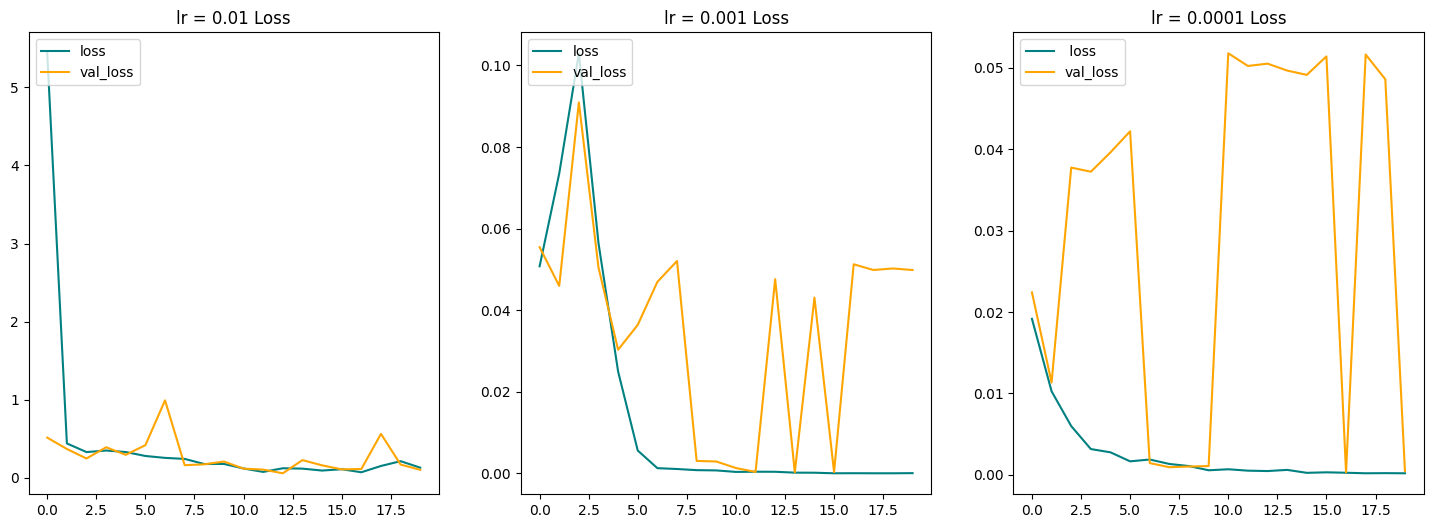

In [33]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(hist1.history['loss'], color='teal', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
plt.title('lr = 0.01 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(132)
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
plt.title('lr = 0.001 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(133)
plt.plot(hist3.history['loss'], color='teal', label=' loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
plt.title('lr = 0.0001 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.show()

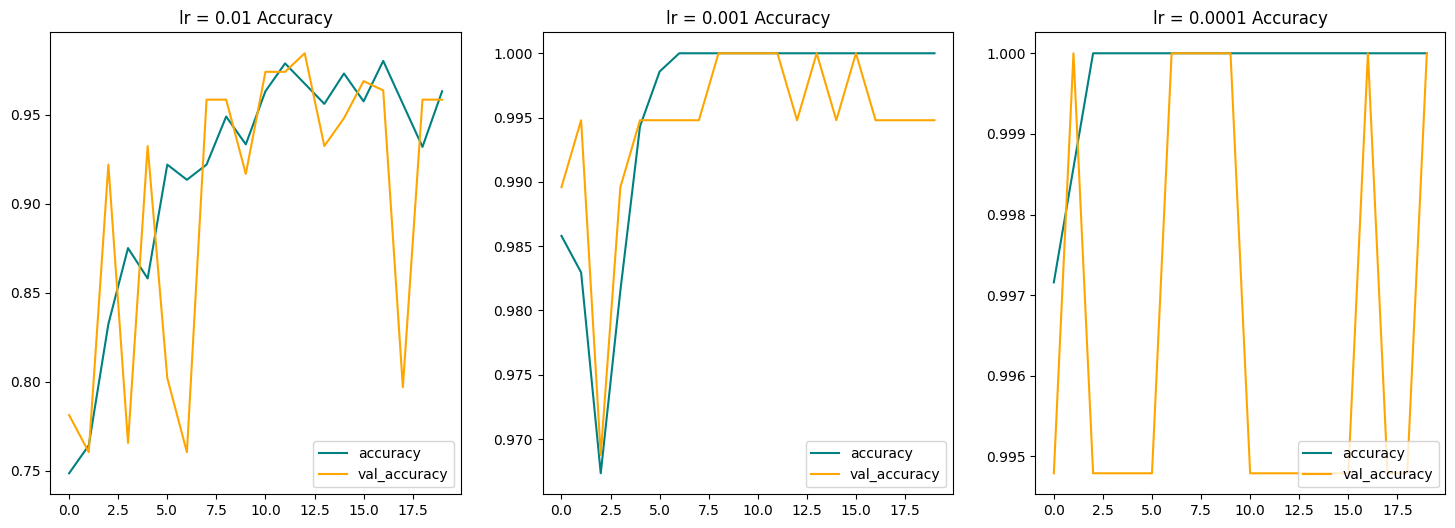

In [34]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.plot(hist1.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist1.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('lr = 0.01 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(132)
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('lr = 0.001 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(133)
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('lr = 0.0001 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.show()

**<h3>옵티마이저 조정</h3>**

In [35]:
model4= clone_model(model)
model4.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model4.set_weights(model.get_weights())

In [36]:
hist4 = model4.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step - accuracy: 0.9963 - loss: 0.0170 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 750ms/step - accuracy: 0.9997 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0121
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 761ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.9948 - val_loss: 0.0331
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 749ms/step - accuracy: 0.9995 - loss: 0.0058 - val_accuracy: 0.9948 - val_loss: 0.0420
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 750ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9948 - val_loss: 0.0394
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 751ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9948 - val_loss: 0.0396
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 772ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accu

<h5>확률적 경사 하강법</h5>

In [37]:
model5 = clone_model(model)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model5.set_weights(model.get_weights())

In [38]:
hist5 = model5.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - accuracy: 0.9897 - loss: 0.0259 - val_accuracy: 0.9844 - val_loss: 0.0448
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - accuracy: 0.9949 - loss: 0.0121 - val_accuracy: 0.9948 - val_loss: 0.0194
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 803ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9896 - val_loss: 0.0338
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 761ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9948 - val_loss: 0.0241
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9844 - val_loss: 0.0651
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.9974 - loss: 0.0126 - val_accuracy: 0.9948 - val_loss: 0.0424
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 800ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 795ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accu

EfficientNetB0 모델

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2567 - loss: 0.7843 - val_accuracy: 0.7500 - val_loss: 0.6846
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6220 - loss: 0.6725 - val_accuracy: 0.7396 - val_loss: 0.6193
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7966 - loss: 0.5869 - val_accuracy: 0.7292 - val_loss: 0.5942
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7661 - loss: 0.5687 - val_accuracy: 0.7448 - val_loss: 0.5723
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7617 - loss: 0.5570 - val_accuracy: 0.7083 - val_loss: 0.6036
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7705 - loss: 0.5536 - val_accuracy: 0.7292 - val_loss: 0.5835
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7866 - loss: 0.5193 - val_accuracy: 0.7552 - val_loss: 0.5555
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7662 - loss: 0.5495 - val_accuracy: 0.7448 - val_loss:

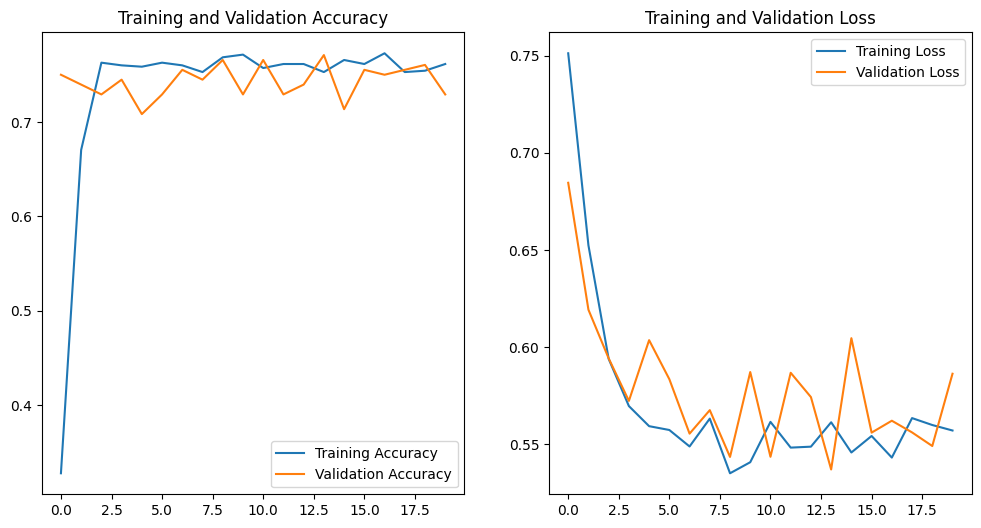

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt


# 사전 학습된 EfficientNetB0 모델 불러오기
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # 사전 학습된 가중치 고정

# 모델 정의
model_EfficientNetB0 = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 모델 컴파일
model_EfficientNetB0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 훈련
hist0 = model_EfficientNetB0.fit(train, epochs=20, validation_data=val)

# 결과 시각화
def plot_training_results(hist0):
    acc = hist0.history['accuracy']
    val_acc = hist0.history['val_accuracy']
    loss = hist0.history['loss']
    val_loss = hist0.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
plot_training_results(hist0)


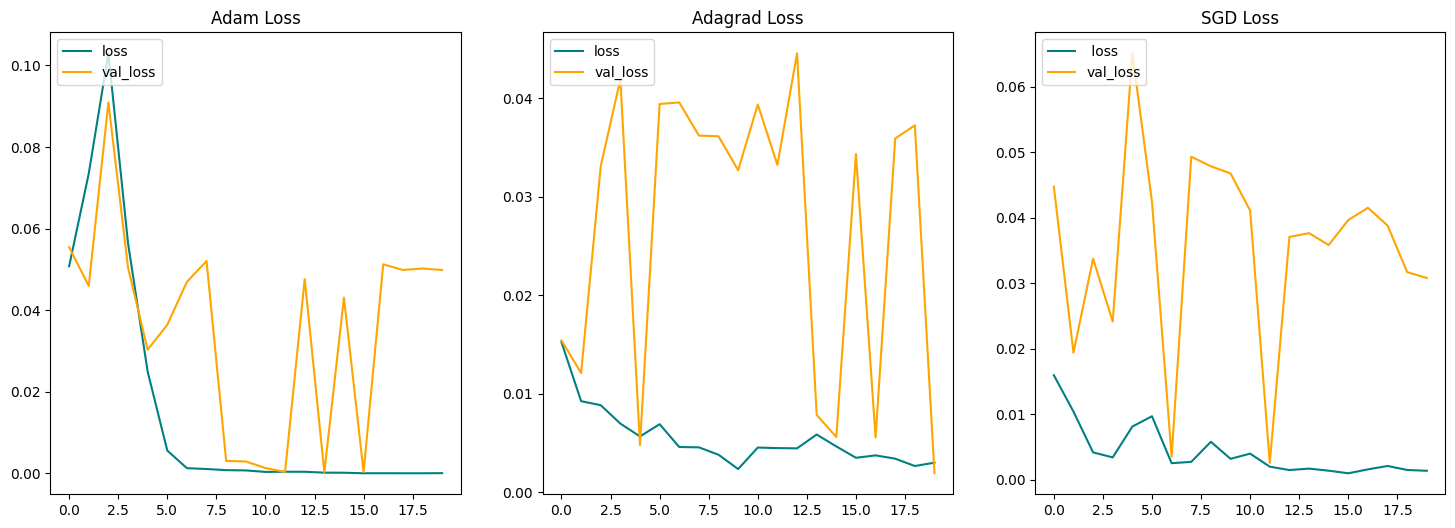

In [40]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
plt.title('Adam Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(132)
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
plt.title('Adagrad Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(133)
plt.plot(hist5.history['loss'], color='teal', label=' loss')
plt.plot(hist5.history['val_loss'], color='orange', label='val_loss')
plt.title('SGD Loss', fontsize=12)
plt.legend(loc="upper left")

plt.show()

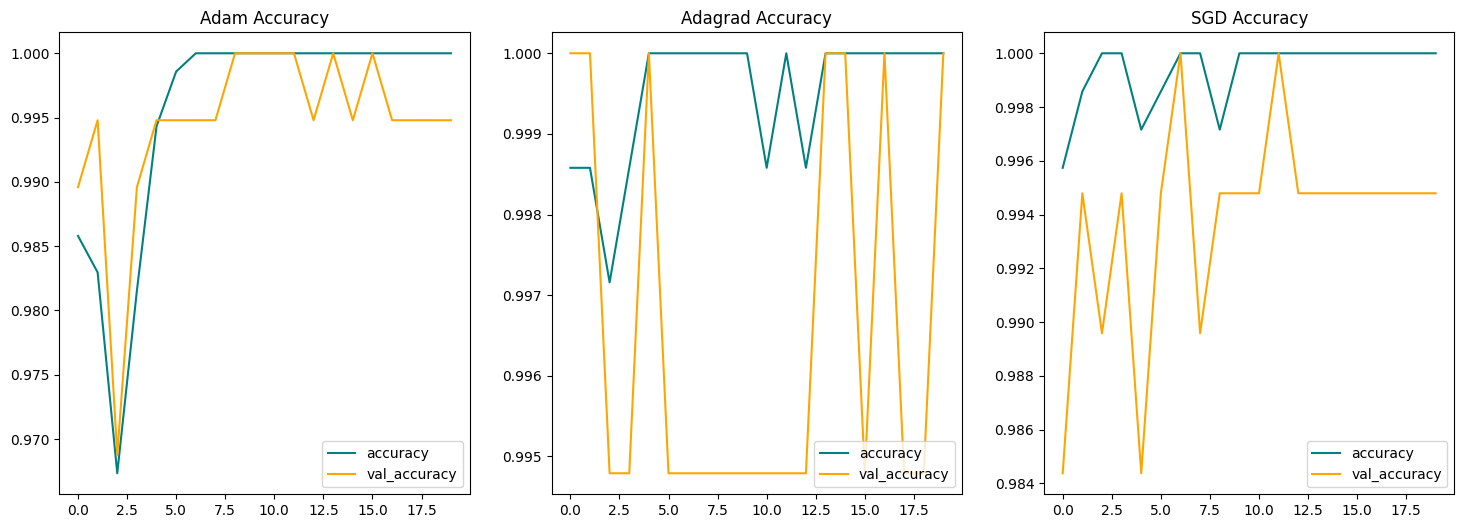

In [41]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Adam Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(132)
plt.plot(hist4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist4.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Adagrad Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(133)
plt.plot(hist5.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist5.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('SGD Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.show()

**<h4>최종 모델</h4>**

In [42]:
model_v4 = Sequential()

model_v4.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_v4.add(MaxPooling2D())
model_v4.add(Conv2D(32, (3,3), 1, activation='relu'))
model_v4.add(MaxPooling2D())
model_v4.add(Conv2D(16, (3,3), 1, activation='relu'))
model_v4.add(MaxPooling2D())
model_v4.add(Flatten())

model_v4.add(Dense(256, activation='relu'))
model_v4.add(Dropout(0.5))
model_v4.add(Dense(1, activation='sigmoid'))

In [43]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
model_v4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
hist_v4 = model_v4.fit(train, epochs=20, validation_data=val)   

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 766ms/step - accuracy: 0.6605 - loss: 0.6516 - val_accuracy: 0.7448 - val_loss: 0.5571
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 764ms/step - accuracy: 0.7690 - loss: 0.5356 - val_accuracy: 0.7760 - val_loss: 0.4831
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 905ms/step - accuracy: 0.7724 - loss: 0.4707 - val_accuracy: 0.7552 - val_loss: 0.4047
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 840ms/step - accuracy: 0.8244 - loss: 0.3736 - val_accuracy: 0.8854 - val_loss: 0.3335
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 812ms/step - accuracy: 0.8608 - loss: 0.3141 - val_accuracy: 0.8906 - val_loss: 0.2972
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 765ms/step - accuracy: 0.9076 - loss: 0.2622 - val_accuracy: 0.9427 - val_loss: 0.1878
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 764ms/step - accuracy: 0.9294 - loss: 0.2163 - val_accuracy: 0.9323 - val_loss: 0.1801
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - accuracy: 0.9258 - loss: 0.1841 - val_accu

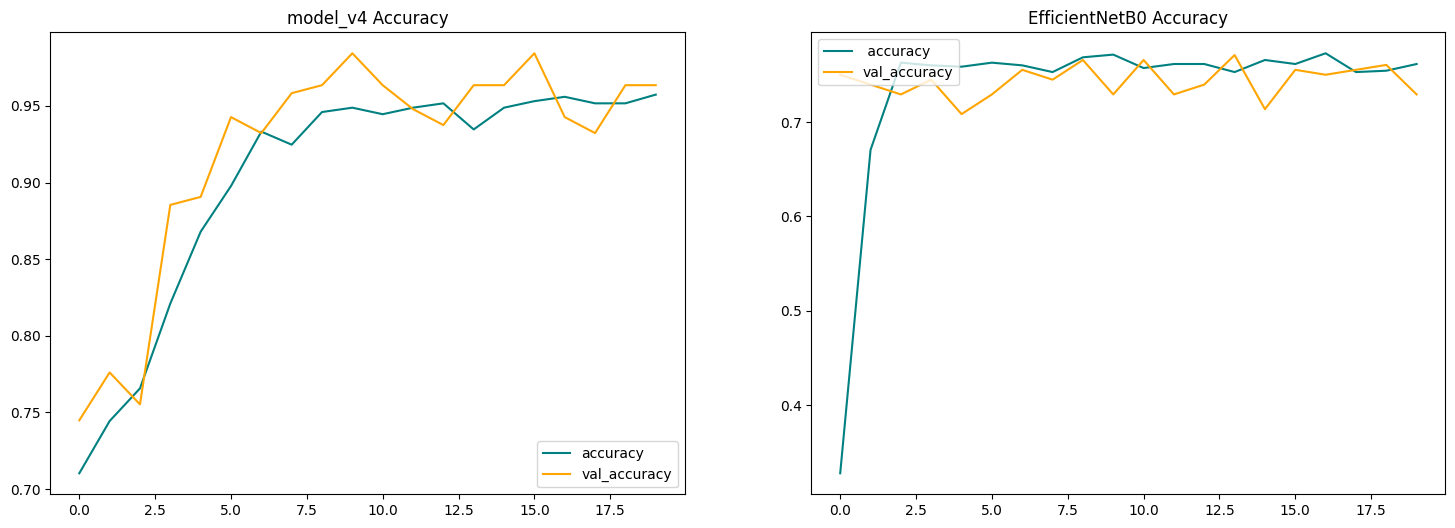

In [45]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist_v4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_v4.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('model_v4 Accuracy', fontsize=12)
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(hist0.history['accuracy'], color='teal', label=' accuracy')
plt.plot(hist0.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('EfficientNetB0 Accuracy', fontsize=12)
plt.legend(loc="upper left")

plt.show()

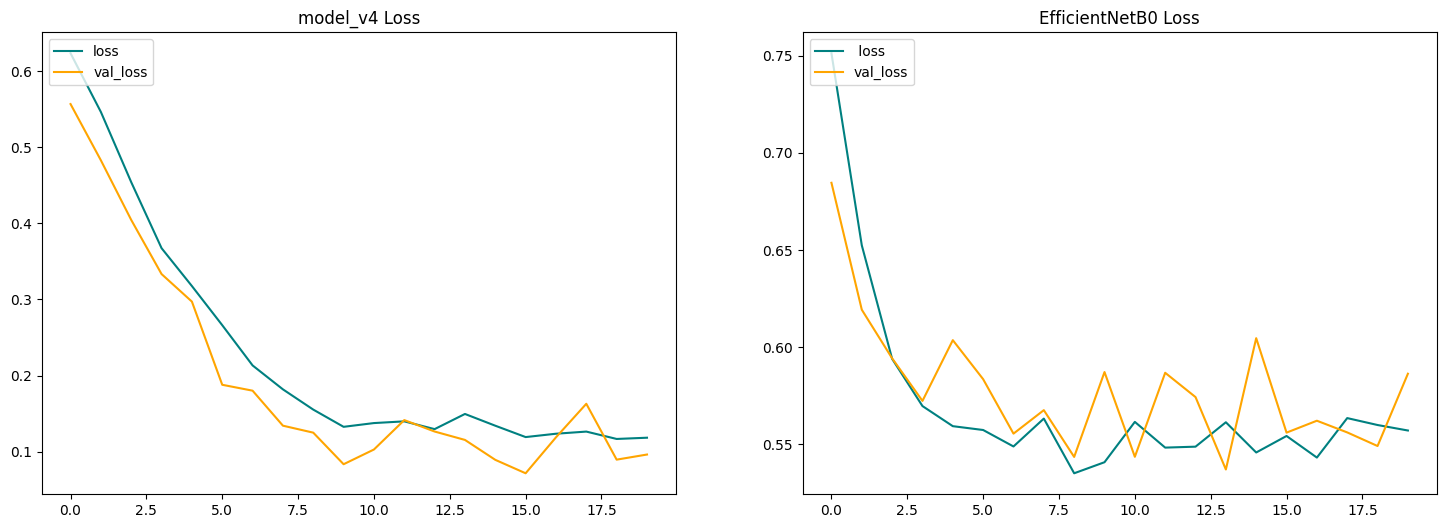

In [46]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(hist_v4.history['loss'], color='teal', label='loss')
plt.plot(hist_v4.history['val_loss'], color='orange', label='val_loss')
plt.title('model_v4 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(hist0.history['loss'], color='teal', label=' loss')
plt.plot(hist0.history['val_loss'], color='orange', label='val_loss')
plt.title('EfficientNetB0 Loss', fontsize=12)
plt.legend(loc="upper left")

plt.show()

**<h4> 최종 모델 평가 </h4>**

In [47]:
#최적의 모델은 아니고 임의로 정한 모델입니다.(수정)
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model_v4.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('precision: {}'.format(pre.result()))
print('recall: {}'.format(re.result()))
print('accuracy: {}'.format(acc.result()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
precision: 1.0
recall: 0.774193525314331
accuracy: 0.9270833134651184


2024-12-10 17:53:08.027231: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


2024-12-10 17:53:11.548581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


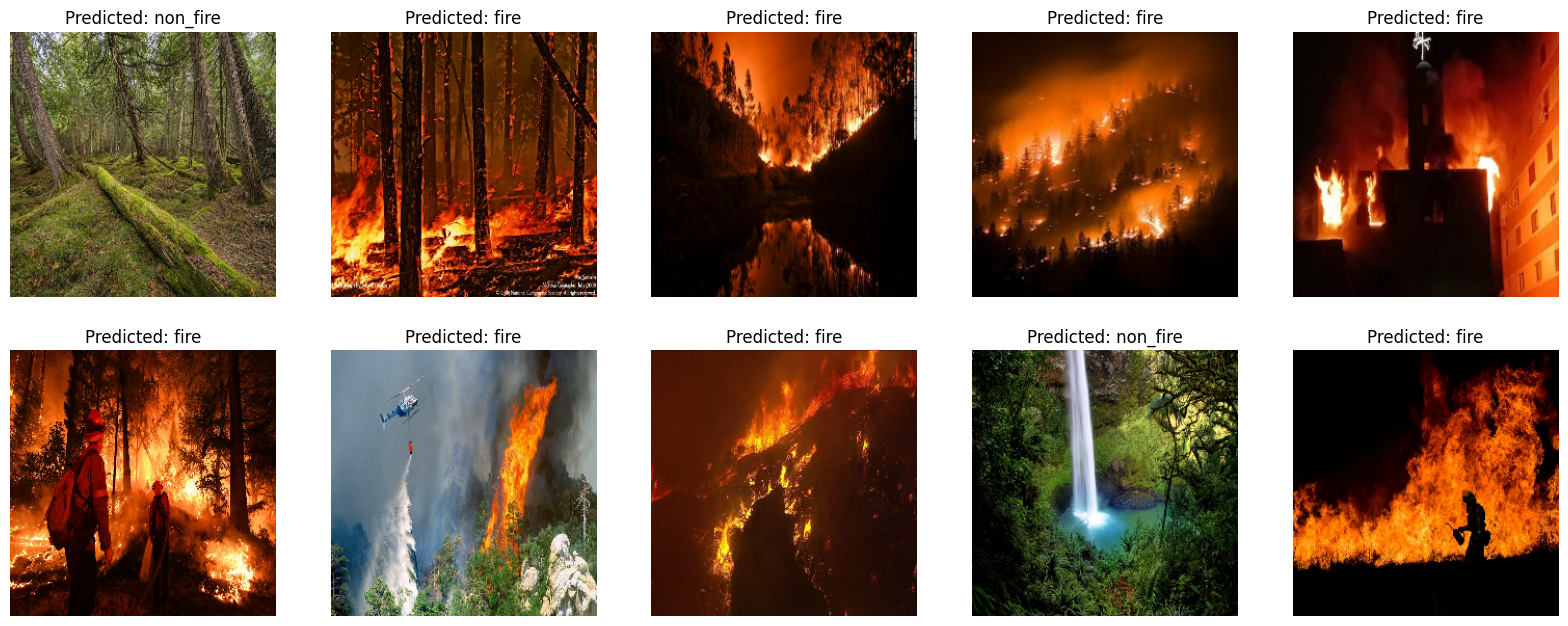

In [48]:
for images, labels in test.take(1):
    test_images = images[:10]
    test_labels = labels[:10]

predictions = model_v4.predict(test_images)

def get_label_name(pred):
    return 'fire' if pred < 0.5 else 'non_fire'

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {get_label_name(predictions[i])}")
    plt.axis('off')
plt.show()